In [1]:
import os
import re
import glob
import nltk
import numpy as np
import pandas as pd
import pandas_access as mdb
import zipfile

from os.path import join, basename
from meza import io
from params import get_params
from nltk.tokenize import word_tokenize
pd.set_option("display.max_columns", 150)

In [2]:
params = get_params()
path = '/Users/pierredelice/Library/CloudStorage/Dropbox/Mac/Documents/GitHub/Dgis/Data/nacimiento/'
file = glob.glob(join(path,r'*.csv'))
file_zip = glob.glob(join(path,r'*.zip'))
nacimiento_2020 = 'nac_unzip/Nacimientos_cierre_2020/Nacimientos_cierre_2020.csv'

for arc_name in glob.iglob(os.path.join(path, "*.zip")):
    arc_dir_name = os.path.splitext(os.path.basename(arc_name))[0]
    zf = zipfile.ZipFile(arc_name)
    zf.extractall(path=os.path.join(path, "nac_unzip", arc_dir_name))
    zf.close()  # Close file after extraction is completed

#Iterate through folders, directories and subdirectories.
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

#files_mdb =list_files(join(path,'nac_unzip'))

Access to database

In [3]:
## Access Birth 2020

#Select columns 
cols = ['FOLIO','NOMBRE','PRIMERAPELLIDO','SEGUNDOAPELLIDO','CURPMADRE',
'FECHANACIMIENTOMADRE','ENTIDADNACIMIENTO','ENTIDADNACIMIENTOD',
'MUNICIPIONACIMIENTO','MUNICIPIONACIMIENTOD',
'ENTIDADRESIDENCIA','ENTIDADRESIDENCIAD','MUNICIPIORESIDENCIA',
'MUNICIPIORESIDENCIAD','LOCALIDADRESIDENCIA','LOCALIDADRESIDENCIAD',
'HIJOSNACIDOSMUERTOS','HIJOSNACIDOSVIVOS','CERTIFICADODEFUNCION',
'AFILIACION','AFILIACIOND','FECHANACIMIENTO','HORANACIMIENTO','SEXO',
'ENTIDADFEDERATIVAPARTO','ENTIDADFEDERATIVAPARTOD','MUNICIPIOPARTO',
'MUNICIPIOPARTOD','LOCALIDADPARTO','LOCALIDADPARTOD','CODIGOPOSTALPARTO']

#Columns to rename
name = {'PRIMERAPELLIDO':'paterno',
'SEGUNDOAPELLIDO':'materno',
'CURPMADRE':'curp',
'FECHANACIMIENTOMADRE':'fech_nac_madre',
'ENTIDADNACIMIENTO':'ent_nac_madre',
'MUNICIPIONACIMIENTO':'mun_nac_madre',
'ENTIDADRESIDENCIA':'ent_res',
'MUNICIPIORESIDENCIA':'mun_res',
'LOCALIDADRESIDENCIA':'local_res',
'HIJOSNACIDOSMUERTOS':'hijos_muertos',
'HIJOSNACIDOSVIVOS':'hijos_vivos',
'FECHANACIMIENTO':'fech_nac',
'ENTIDADFEDERATIVAPARTO':'ent_parto',
'MUNICIPIOPARTO':'mun_parto',
'LOCALIDADPARTO':'localidad_parto'}

#Read data
nac2020 = pd.read_csv(join(path,nacimiento_2020), usecols= cols, low_memory=False)

#Rename columns
nac2020.rename(columns=name, inplace =True)

#To lower case columns
nac2020.columns = [x.lower() for x in nac2020.columns]


#To lower strings columns
nac2020 = nac2020.apply(lambda x: x.astype(str).str.lower())

#Convert to string
nac2020 = nac2020.convert_dtypes()

#Create fullname: Nombre + Apellido materno y paterno
nac2020['name'] = nac2020[['nombre', 'paterno', 'materno']].agg(' '.join, axis=1)

Entity cleansing

In [57]:
#Selección de los registros a corregir
RE_SUSPICIOUS = re.compile(r'desconocido|se ignora|sin informacion|[&#<>{}\[\]\\]')

def impurity(text, min_len=3):
    """returns the share of suspicious characters in a text""" 
    if text == None or len(text) < min_len:
        return 0 
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

# add new column to data frame
nac2020['impurity_before'] = nac2020['name'].apply(impurity, min_len=3)

# get the top 3 records
nac2020[['name', 'impurity_before']].sort_values(by='impurity_before', ascending=False)

,name,impurity_before
769960,sin informacion sin informacion sin informacion,0.06383
316223,sin informacion sin informacion sin informacion,0.06383
1409568,sin informacion sin informacion sin informacion,0.06383
1694356,sin informacion sin informacion sin informacion,0.06383
1313884,sin informacion sin informacion sin informacion,0.06383
...,...,...
582884,alicia urbina maldonado,0.00000
582883,lourdes ferrer ladino,0.00000
582882,irene huerta ferrer,0.00000
582881,marina morales bajonero,0.00000


In [10]:
len(nac2020[nac2020.impurity_before>0])

2306

In [63]:
def clean(text):
    # convert html escapes like &amp; to characters.
    #text = html.unescape(text) 
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', '', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', '', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    # Unnecessary words and characters
    text = re.sub(r'desconocido|se ignora|sin informacion|informacion|[&#<>{}\[\]\\]','', text)
    return text

nac2020['clean_name'] = nac2020['name'].map(clean)
#nac2020['impurity'] = nac2020['clean_name'].apply(impurity, min_len=3)
#nac2020[['clean_name', 'impurity']].sort_values(by='impurity', ascending=False).head(3)
nac2020[nac2020['clean_name'].apply(impurity, min_len=3) > 0]

,folio,curp,nombre,paterno,materno,fech_nac_madre,ent_nac_madre,entidadnacimientod,mun_nac_madre,municipionacimientod,ent_res,entidadresidenciad,mun_res,municipioresidenciad,local_res,localidadresidenciad,hijos_muertos,hijos_vivos,certificadodefuncion,afiliacion,afiliaciond,fech_nac,horanacimiento,sexo,ent_parto,entidadfederativapartod,mun_parto,municipiopartod,localidad_parto,localidadpartod,codigopostalparto,name,impurity_before,clean_name


In [71]:
from collections import Counter

counter = Counter()

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # process tokens and update counter 
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data 
    counter = Counter() 
    
    df[column].map(update)

    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq']) 
    freq_df = freq_df.query('freq >= @min_freq') 
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

count_words(nac2020, column='clean_name', preprocess=lambda t: re.findall(r'desconocido|se ignora|sin informacion|[?&#<>{}\[\]\\]*', t))

,freq
token,
,47357809


In [75]:
nac2020[['clean_name','name','nombre','paterno','materno']].isnull().sum()

clean_name    0
name          0
nombre        0
paterno       0
materno       0
dtype: int64

In [78]:
(nac2020[['name','clean_name']].nunique()/len(nac2020))

name          0.948284
clean_name    0.948025
dtype: float64

<AxesSubplot: >

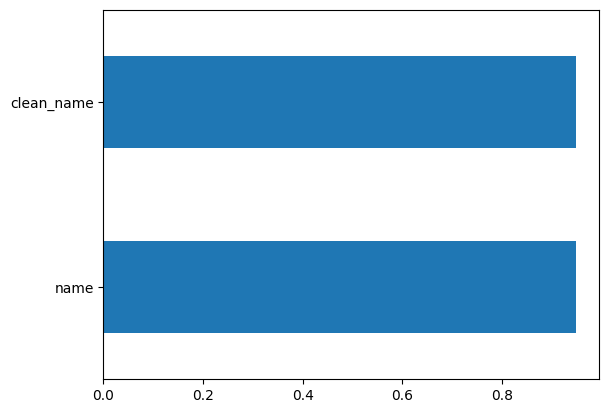

In [79]:
(nac2020[['name','clean_name']].nunique()/len(nac2020)).plot(kind='barh')

In [80]:
pd.DataFrame(nac2020.groupby(['clean_name']).value_counts())

0
clean_name                       folio     curp               nombre           paterno         materno         fech_nac_madre ent_nac_madre entidadnacimientod              mun_nac_madre municipionacimientod ent_res entidadresidenciad              mun_res municipioresidenciad local_res localidadresidenciad           hijos_muertos hijos_vivos certificadodefuncion afiliacion afiliaciond             fech_nac   horanacimiento sexo ent_parto entidadfederativapartod         mun_parto municipiopartod localidad_parto localidadpartod    codigopostalparto name                                            impurity_before   
                                 026218642 xxxx999999xxxxxx99 sin informacion  sin informacion sin informacion 30/11/1999     0             no especificado                 999           no especificado      99      se ignora                       999     no especificado      9999      no especificado                0             1           nan                  0          no especificado         09/08/2020 12:00          1    2         baja california                 2         mexicali        1               mexicali           99999.0           sin informacion sin informacion sin informacion 0.06383          1
                                 026313061 xxxx999999xxxxxx99 sin informacion  sin informacion sin informacion 17/11/1996     5             coahuila de zaragoza            18            monclova             5       coahuila de zaragoza            30      saltillo             1         saltillo                       0             1           nan                  1          ninguna                 29/02/2020 08:55          1    5         coahuila de zaragoza            30        saltillo        1               saltillo           99999.0           sin informacion sin informacion sin informacion 0.06383          1
                                 028140250 raln960324mvzmnj01 sin informacion  sin informacion sin informacion 24/03/1996     30            veracruz de ignacio de la llave 124           papantla             30      veracruz de ignacio de la llave 124     papantla             155       adolfo lopez mateos (taracuan) 0             1           nan                  7          seguro popular / insabi 14/01/2020 17:15          1    30        veracruz de ignacio de la llave 124       papantla        1               papantla de olarte 93430.0           sin informacion sin informacion sin informacion 0.06383          1
                                 027726494 xxxx999999xxxxxx99 sin informacion  sin informacion sin informacion 09/09/9999     99            se ignora                       998           se ignora            21      puebla                          156     tehuacán             1         tehuacan                       99            99          nan                  99         se ignora               17/02/2020 00:00          9    21        puebla                          156       tehuacán        1               tehuacan           75730.0           sin informacion sin informacion sin informacion 0.06383          1
                                 027726031 xxxx999999xxxxxx99 sin informacion  sin informacion sin informacion 09/09/9999     0             no especificado                 999           no especificado      21      puebla                          156     tehuacán             1         tehuacan                       99            99          nan                  7          seguro popular / insabi 06/01/2020 00:00          9    21        puebla                          156       tehuacán        1               tehuacan           75730.0           sin informacion sin informacion sin informacion 0.06383          1
...                                                                                                                                                                                                                                                                                               

from mdb_parser import MDBParser, MDBTable

db = MDBParser(file_path=files_mdb[2])


# Get and print the database tables
print(db.tables)

# Get a table from the DB.
table = db.get_table("NACIMIENTO")

# Or you can use the MDBTable class.
table = MDBTable(file_path=files_mdb[2], table="NACIMIENTO")

# Get and print the table columns.
print(table.columns)

# Iterate the table rows.
#for row in table:
#    print(row)


nacimiento = []
for row in table:
    nacimiento.append(row)

cols = ['FOLIO','NOMBRE','PATERNO','MATERNO','CURP_M','ENT_NACM','MPO_NACM','FECH_NACM', 
'EDOCIVIL','CALLE_RES','ENT_RES','MPO_RES','LOC_RES','HIJO_SOBV','CERTDEF',
 'DERHAB','NIV_ESCOL','OCUPHAB','FECH_NACH','HORA_NACH','SEXOH']

nac_sample = pd.DataFrame(nacimiento, columns = table.columns)
nac_sample = nac_sample[cols] 
nac_sample = nac_sample.sample(n=10000, random_state=1)
nac_sample.columns = nac_sample.columns.str.lower()

nac_sample[['nombre', 'paterno', 'materno', 'calle_res', 'ocuphab']] = \
    (nac_sample[['nombre', 'paterno', 'materno', 'calle_res', 'ocuphab']]
    .astype('category')
    .apply(lambda x: x.str.lower()))

In [ ]:
nac_sample['nombre'].value_counts().plot()